In [1]:
#importing various libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dython.nominal import associations
from dython.nominal import identify_nominal_columns

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier

In [2]:
data=pd.read_csv("thyroidDF.csv")

In [3]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [4]:
data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target', 'patient_id'],
      dtype='object')

In [5]:
print("Number of records: ",data.shape[0])
print("Number of features: ",data.shape[1])

Number of records:  9172
Number of features:  31


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

In [7]:
data.isnull().sum()

age                       0
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,9172.0,7.355582e+01,1.183977e+03,1.000000e+00,3.700000e+01,5.500000e+01,6.800000e+01,6.552600e+04
TSH,8330.0,5.218403e+00,2.418401e+01,5.000000e-03,4.600000e-01,1.400000e+00,2.700000e+00,5.300000e+02
T3,6568.0,1.970629e+00,8.875788e-01,5.000000e-02,1.500000e+00,1.900000e+00,2.300000e+00,1.800000e+01
TT4,8730.0,1.087003e+02,3.752267e+01,2.000000e+00,8.700000e+01,1.040000e+02,1.260000e+02,6.000000e+02
T4U,8363.0,9.760557e-01,2.003604e-01,1.700000e-01,8.600000e-01,9.600000e-01,1.065000e+00,2.330000e+00
FTI,8370.0,1.136407e+02,4.155165e+01,1.400000e+00,9.300000e+01,1.090000e+02,1.280000e+02,8.810000e+02
TBG,349.0,2.987006e+01,2.108050e+01,1.000000e-01,2.100000e+01,2.600000e+01,3.100000e+01,2.000000e+02
patient_id,9172.0,8.529473e+08,7.581969e+06,8.408010e+08,8.504090e+08,8.510040e+08,8.607110e+08,8.701190e+08


In [9]:
data.corr()

,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
age,1.000000,-0.003979,0.004523,0.004122,-0.002045,0.004108,-0.122787,0.018506
TSH,-0.003979,1.000000,-0.159372,-0.275915,0.075857,-0.275468,-0.117742,-0.007083
T3,0.004523,-0.159372,1.000000,0.550381,0.345649,0.370423,-0.012619,0.038595
TT4,0.004122,-0.275915,0.550381,1.000000,0.368754,0.751199,-0.025716,0.023888
T4U,-0.002045,0.075857,0.345649,0.368754,1.000000,-0.238970,0.614947,-0.039248
FTI,0.004108,-0.275468,0.370423,0.751199,-0.238970,1.000000,-0.200290,0.023166
TBG,-0.122787,-0.117742,-0.012619,-0.025716,0.614947,-0.200290,1.000000,0.087872
patient_id,0.018506,-0.007083,0.038595,0.023888,-0.039248,0.023166,0.087872,1.000000


In [10]:
# dropping redundant attributes from thyroidDF dataset
data.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'patient_id', 'referral_source'], axis=1, inplace=True)

In [11]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
0,29,F,f,f,f,f,f,f,f,t,...,f,f,f,0.3,NaN,NaN,NaN,NaN,NaN,-
1,29,F,f,f,f,f,f,f,f,f,...,f,f,f,1.6,1.9,128.0,NaN,NaN,NaN,-
2,41,F,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,NaN,NaN,NaN,11.0,-
3,36,F,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,NaN,NaN,NaN,26.0,-
4,32,F,f,f,f,f,f,f,f,f,...,f,f,f,NaN,NaN,NaN,NaN,NaN,36.0,S


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

In [13]:
# re-mapping target vaues to diagnostic groups
diagnoses = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'E': 'hypothyroid', 
             'F': 'hypothyroid', 
             'G': 'hypothyroid', 
             'H': 'hypothyroid'}

In [14]:
data['target'] = data['target'].map(diagnoses) # re-mapping

In [15]:
# dropping observations with 'target' null after re-mapping
data.dropna(subset=['target'], inplace=True) 

In [16]:
# dataset initial summary
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7546 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7546 non-null   int64  
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   o

In [17]:
# distributions of numeric variables
data.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,7546.000000,6824.000000,5337.000000,7192.000000,6870.000000,6877.000000,259.000000
mean,78.013782,5.421753,2.020935,105.203373,0.967322,110.571745,22.955019
std,1305.258137,26.080471,0.809865,32.606462,0.162315,36.600867,6.088392
min,1.000000,0.005000,0.050000,2.000000,0.190000,1.400000,0.100000
25%,37.000000,0.570000,1.600000,87.000000,0.870000,93.000000,20.000000
50%,55.000000,1.400000,2.000000,103.000000,0.960000,108.000000,23.000000
75%,67.000000,2.700000,2.300000,121.000000,1.060000,125.000000,27.000000
max,65526.000000,530.000000,18.000000,430.000000,2.120000,839.000000,45.000000


In [18]:
# inspecting observations with age > 100
data[data.age > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
2976,455,F,f,f,f,f,f,f,f,f,...,f,f,f,1.10,2.0,118.0,1.13,104.0,NaN,negative
5710,65511,M,f,f,f,f,f,f,f,f,...,f,f,f,0.38,2.0,113.0,1.08,104.0,NaN,negative
6392,65512,M,f,f,f,f,f,f,f,f,...,f,f,f,0.03,2.8,112.0,0.84,133.0,NaN,negative
8105,65526,F,f,f,f,f,f,f,f,f,...,f,f,f,1.50,NaN,132.0,1.02,129.0,NaN,negative


In [19]:
# changing age of observations with ('age' > 100) to null
data['age'] = np.where((data.age > 100), np.nan, data.age)

Exploratory Data Analysis

We begin our EDA by looking at the distribution of Hormone levels in blood for each of our target classes. This helps us get an idea for how good of a predictor each of these attributes can be

<Axes: xlabel='target', ylabel='TBG'>

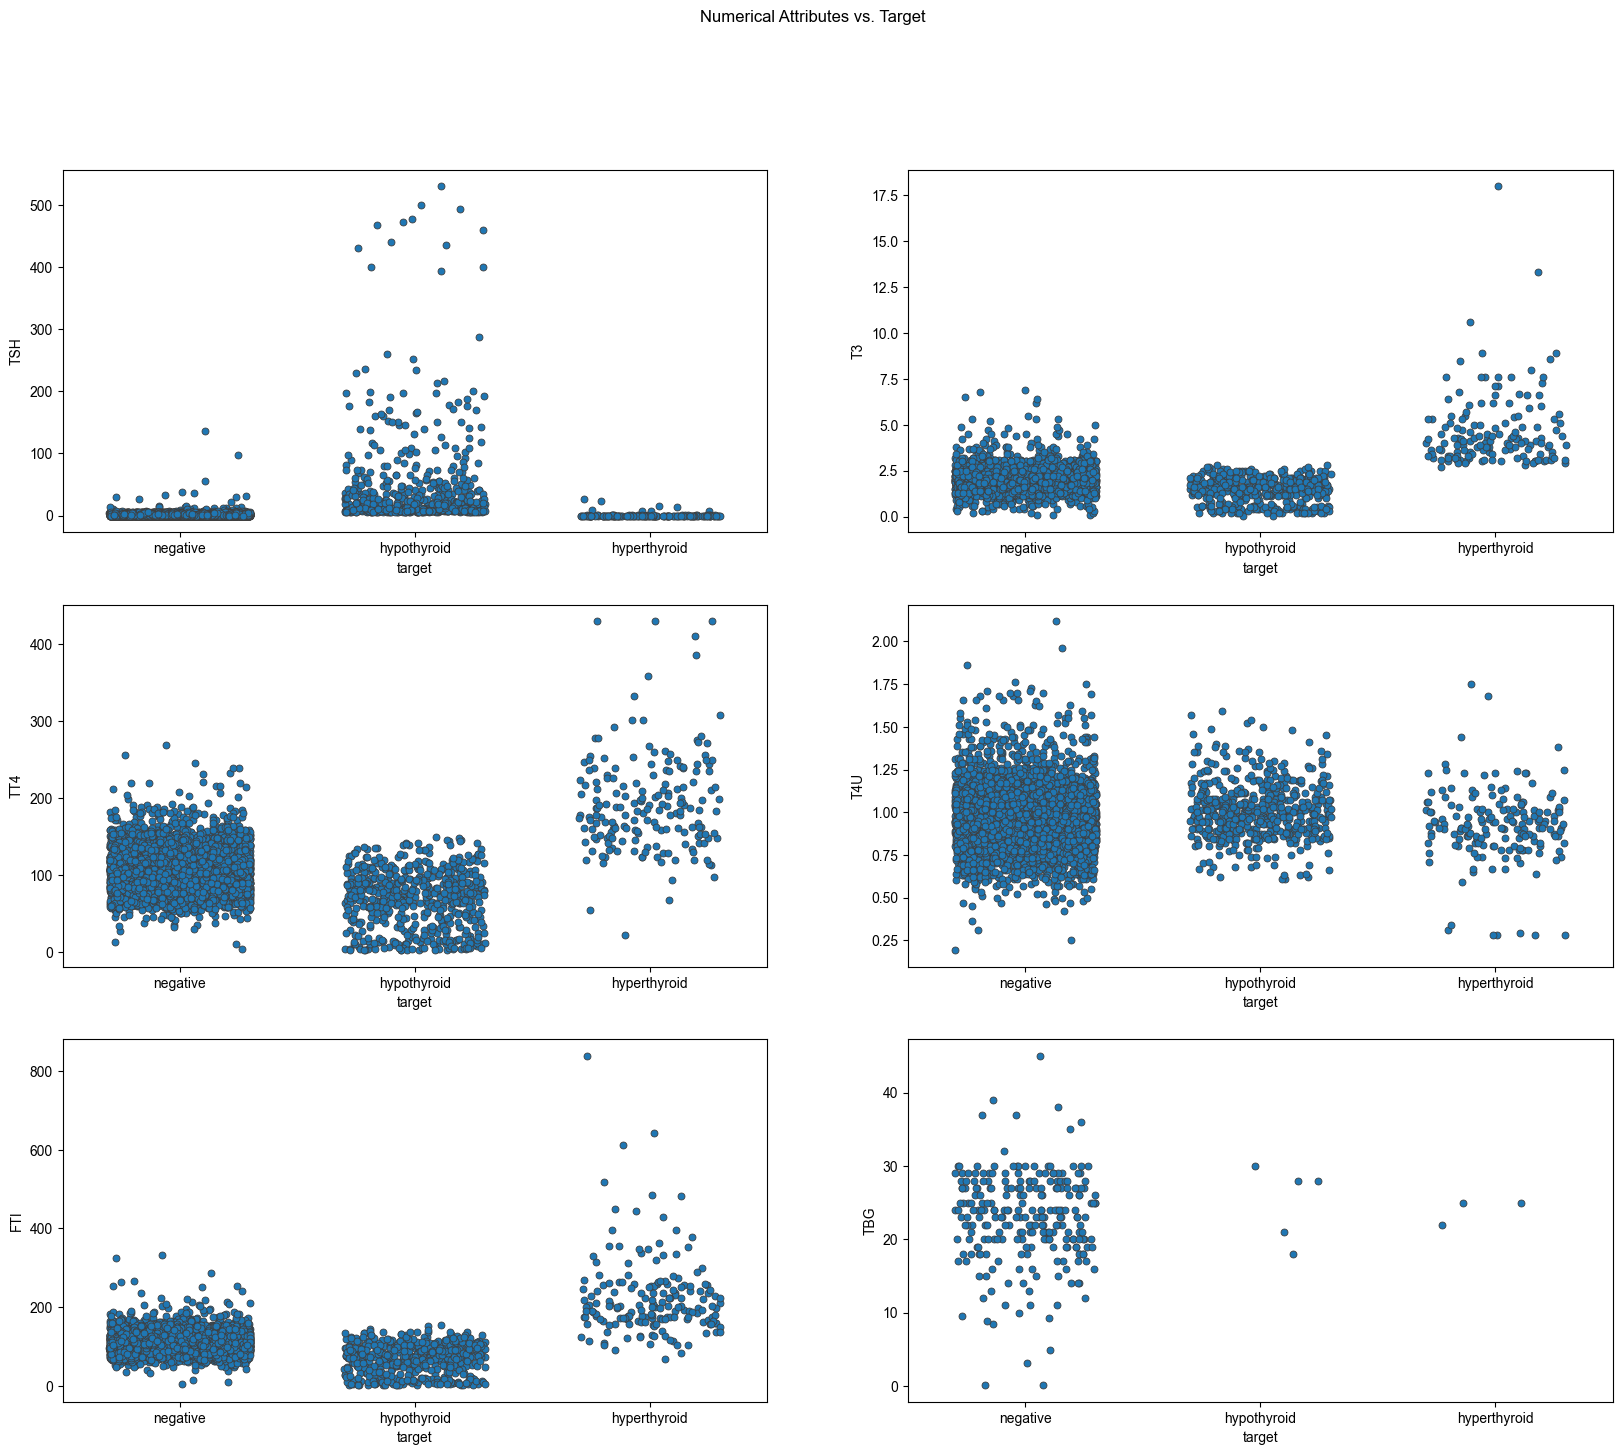

In [20]:
# setting up grid for multiple seaborn plots
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Numerical Attributes vs. Target')
sns.set_style('whitegrid');

# plotting numerical attributes

# TSH vs. 'target'
sns.stripplot(x=data.target, y=data.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs. 'target'
sns.stripplot(x=data.target, y=data.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs. 'target'
sns.stripplot(x=data.target, y=data.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs. 'target'
sns.stripplot(x=data.target, y=data.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs. 'target'
sns.stripplot(x=data.target, y=data.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs. 'target'
sns.stripplot(x=data.target, y=data.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1])

Observations:

Immediately we can hypothesize that FTI, T3, and TT4 will be good feature additions to our models. TSH looks like it might be good as well but we need to handle the outliers for 'target' hypo and analyze the attribute distribution further before making any decisions.
This is all in-line with the knowledge discovered about Hormone level tests during our initial research

Let's continue by creating a pairplot of our numeric variables and seeing if we can spot any clusters forming between variables.

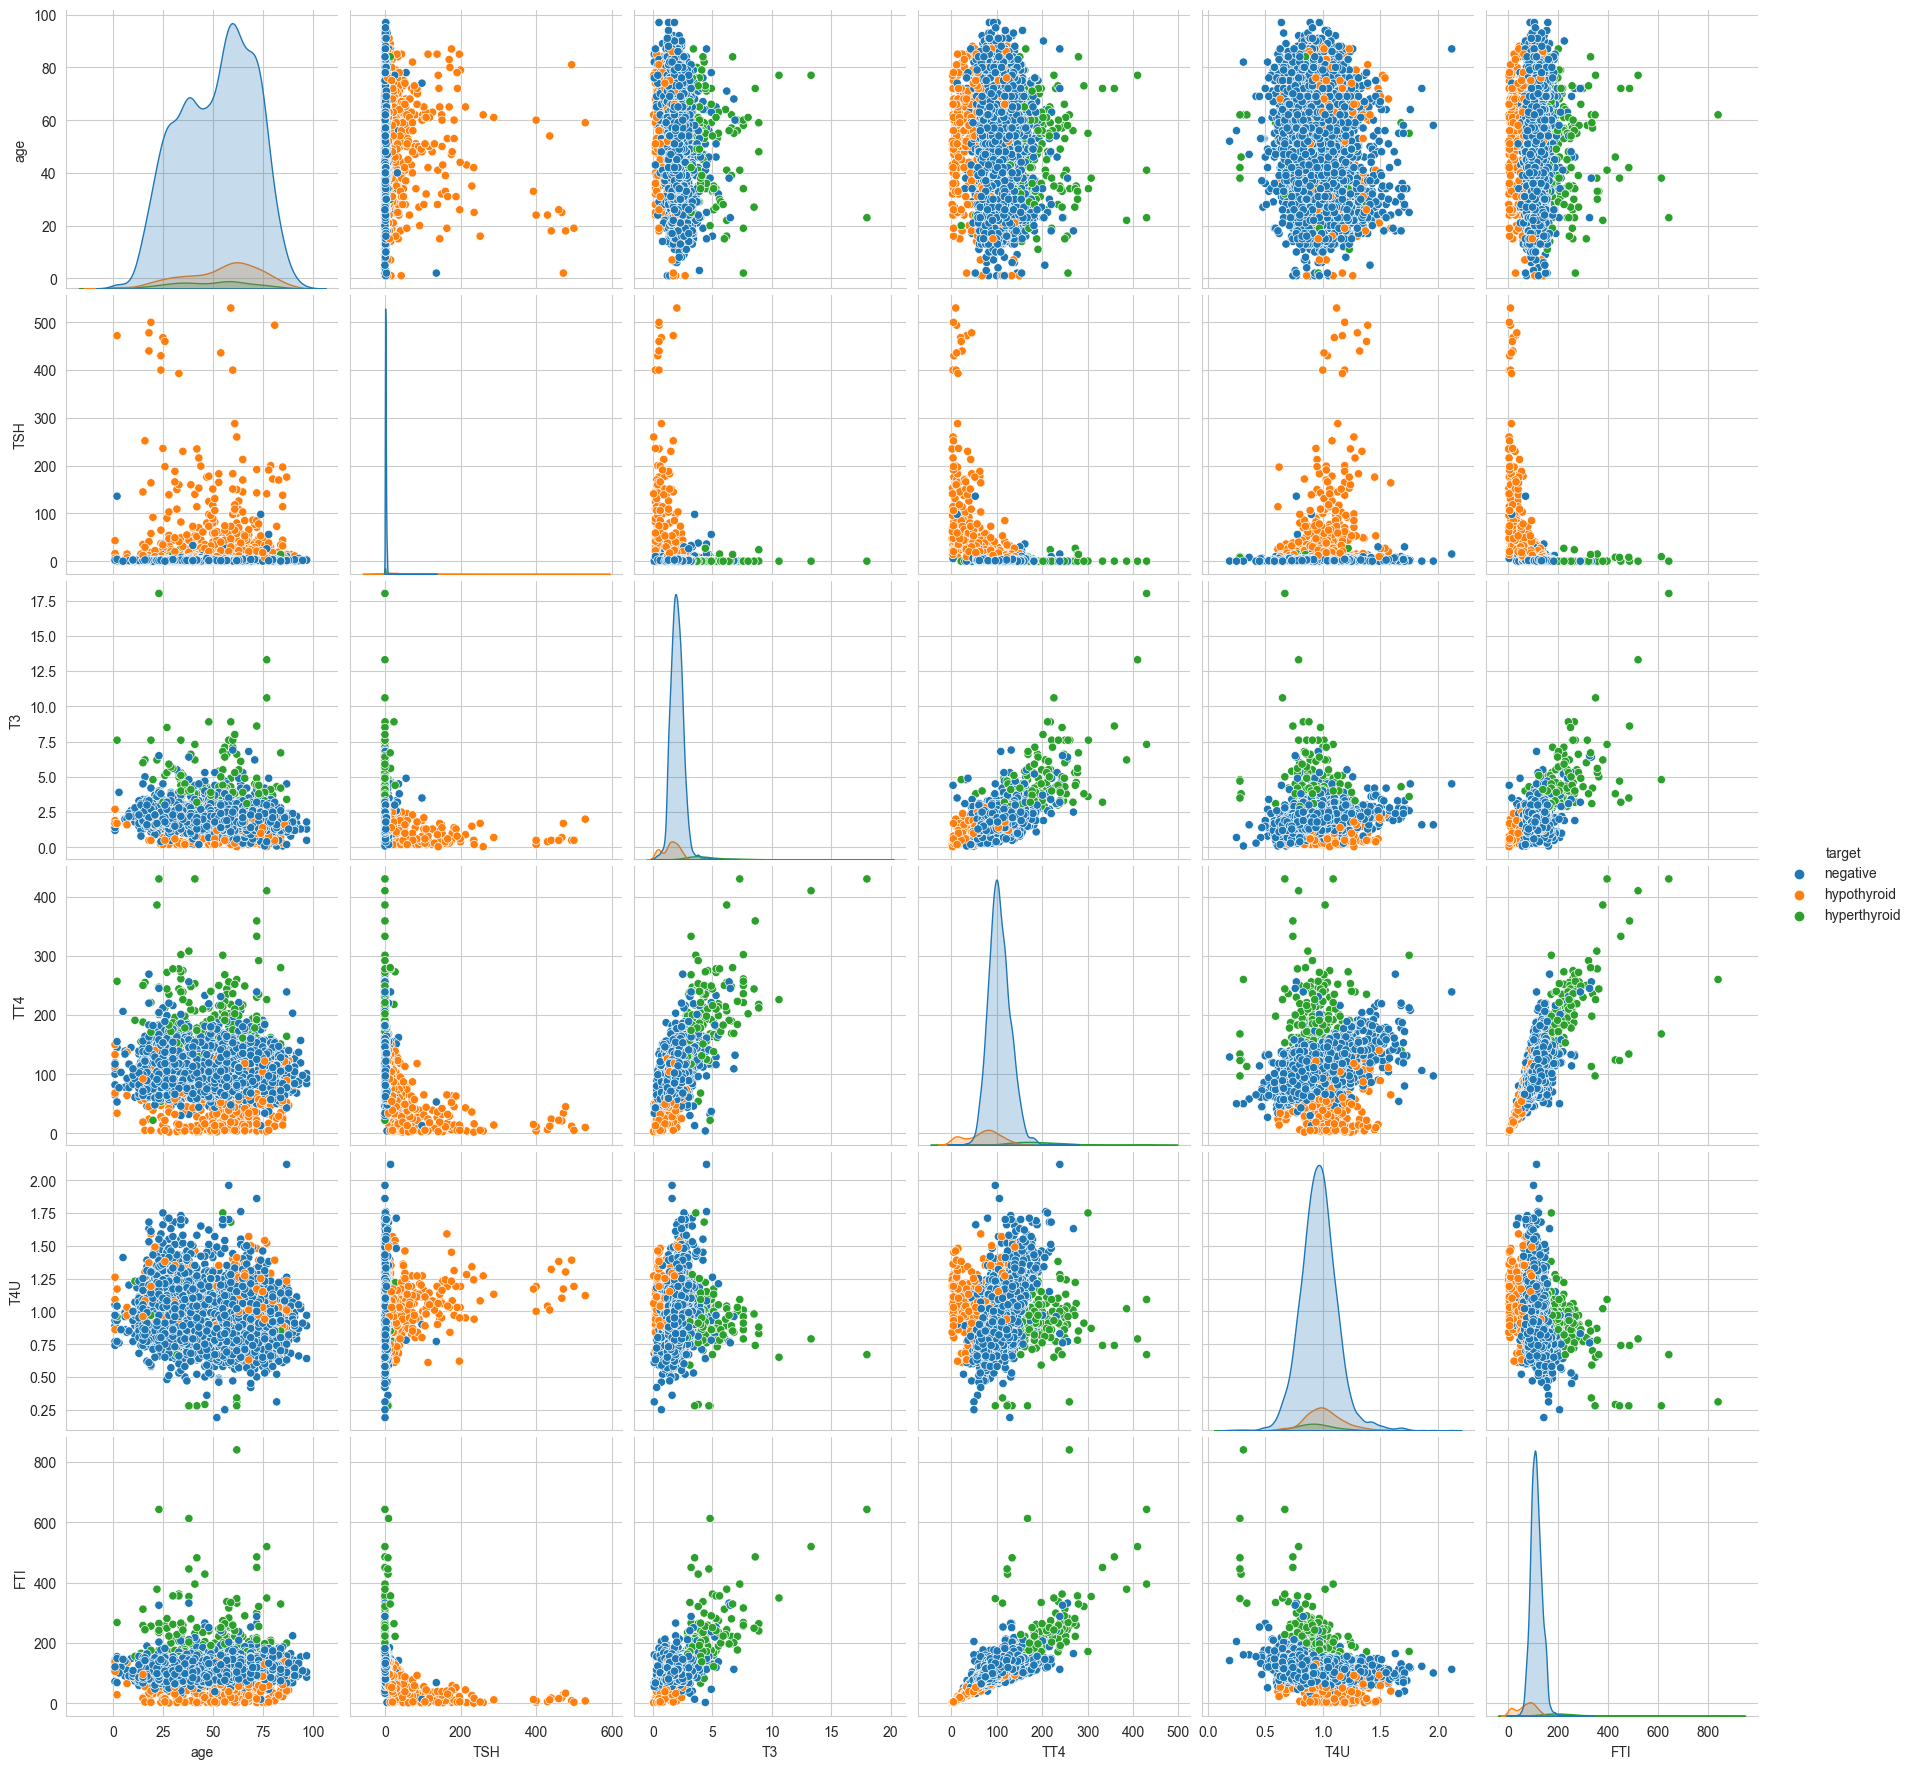

In [21]:
numericalDF = data[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()
sns.set_style('whitegrid');
sns.pairplot(numericalDF, hue='target', height=3);
plt.show()

In the diagonals of the pairplot we can see the distributions of each numeric variable with respect to one another. It is apparent how unbalanced the dataset is, with so many negative 'target' compared to hypothyroid or hyperthyroid.

Observations:

We can see that for some Hormone test vs others there are nice clusters that form. This is encouragin because it means that they do a good job at separating out each of our target classes.
FTI vs T3
FTI vs T4U
FTI vs age
T4U vs TT4
TT4 vs age
TT4 vs T3

There is severe target class imbalance... but we knew this from the start. It is normal for this type of data. We will have to treat with resampling protocol as well as using models that handle this well
XGBoost would be a good option

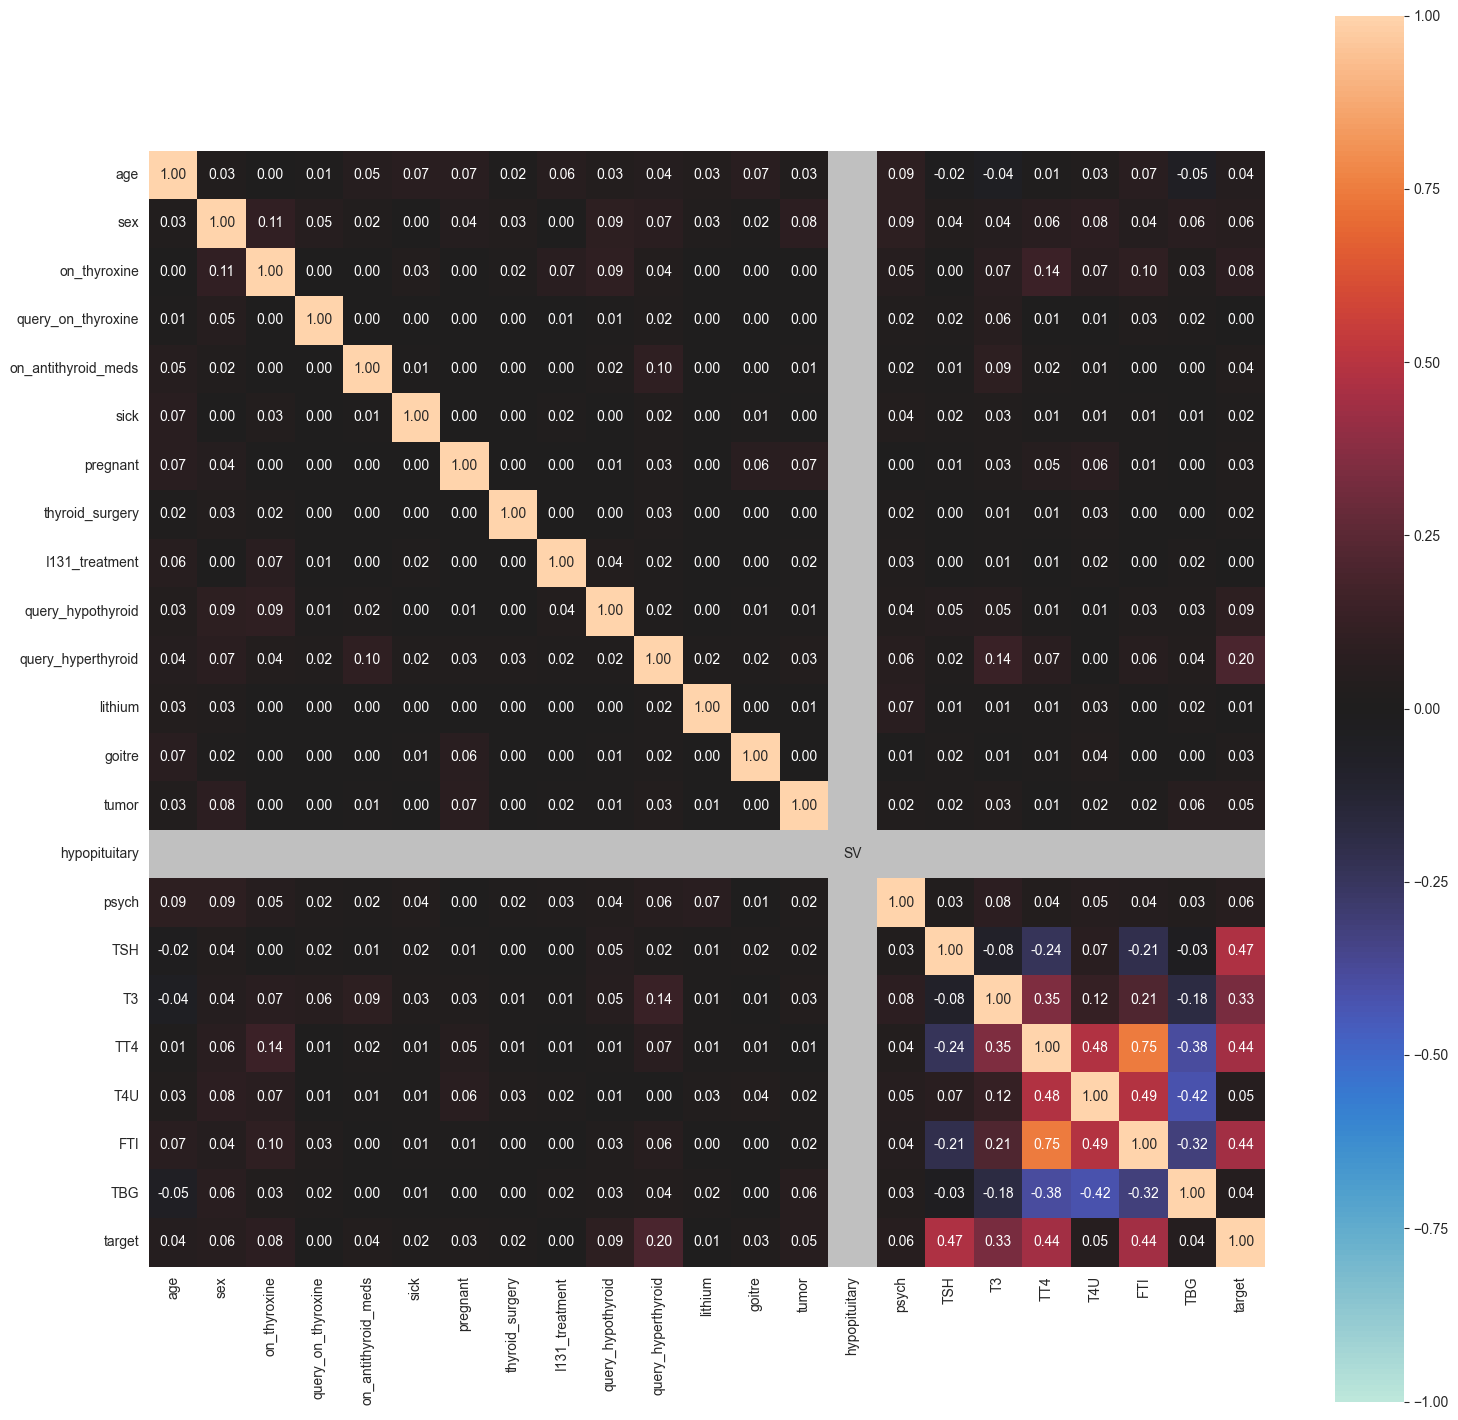

In [22]:
categorical_features = identify_nominal_columns(data)
associations(data, 
            nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson',  
            ax=None, annot=True, fmt='.2f',cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, 
            compute_only=False, clustering=False, title=None, filename=None, 
            figsize=(18,18));

Very nice to have all this information about the correlation of all our attributes in the same place. Immediately we confirm our hypothesis that the Hormone tests are the most helpful in our aim to predict target diagnosis. Surprising though that almost no other of our attributes do a good job at predicting our target. We will decide how to move on with this when we analyze a bit more.

Handling Inconsistencies

Investigating Outliers

The code below calculates the Inter-quartile ranges for our Hormone test numeric attributes in order to determin mild and sever outliers. Depending on the severity of the issue we will decide how to handle them in the next section.

In [23]:
# TSH
Q1_TSH = data['TSH'].quantile(0.25)
Q3_TSH = data['TSH'].quantile(0.75)
IQR_TSH = Q3_TSH - Q1_TSH
under_TSH = data['TSH'] < (Q1_TSH - 3 * IQR_TSH)
upper_TSH = data['TSH'] > (Q3_TSH + 3 * IQR_TSH)
print('TSH:', 'lower outliers -', sum(under_TSH), ' | upper outliers -', sum(upper_TSH))

# T3
Q1_T3 = data['T3'].quantile(0.25)
Q3_T3 = data['T3'].quantile(0.75)
IQR_T3 = Q3_T3 - Q1_T3
under_T3 = data['T3'] < (Q1_T3 - 3 * IQR_T3)
upper_T3 = data['T3'] > (Q3_T3 + 3 * IQR_T3)
print('T3:', 'lower outliers -', sum(under_T3), ' | upper outliers -', sum(upper_T3))

# TT4
Q1_TT4 = data['TT4'].quantile(0.25)
Q3_TT4 = data['TT4'].quantile(0.75)
IQR_TT4 = Q3_TT4 - Q1_TT4
under_TT4 = data['TT4'] < (Q1_TT4 - 3 * IQR_TT4)
upper_TT4 = data['TT4'] > (Q3_TT4 + 3 * IQR_TT4)
print('TT4:', 'lower outliers -', sum(under_TT4), ' | upper outliers -', sum(upper_TT4))

# T4U
Q1_T4U = data['T4U'].quantile(0.25)
Q3_T4U = data['T4U'].quantile(0.75)
IQR_T4U = Q3_T4U - Q1_T4U
under_T4U = data['T4U'] < (Q1_T4U - 3 * IQR_T4U)
upper_T4U = data['T4U'] > (Q3_T4U + 3 * IQR_T4U)
print('T4U:', 'lower outliers -', sum(under_T4U), ' | upper outliers -', sum(upper_T4U))

# FTI
Q1_FTI = data['FTI'].quantile(0.25)
Q3_FTI = data['FTI'].quantile(0.75)
IQR_FTI = Q3_FTI - Q1_FTI
under_FTI = data['FTI'] < (Q1_FTI - 3 * IQR_FTI)
upper_FTI = data['FTI'] > (Q3_FTI + 3 * IQR_FTI)
print('FTI:', 'lower outliers -', sum(under_FTI), ' | upper outliers -', sum(upper_FTI))

TSH: lower outliers - 0  | upper outliers - 456
T3: lower outliers - 0  | upper outliers - 84
TT4: lower outliers - 0  | upper outliers - 55
T4U: lower outliers - 7  | upper outliers - 22
FTI: lower outliers - 0  | upper outliers - 83


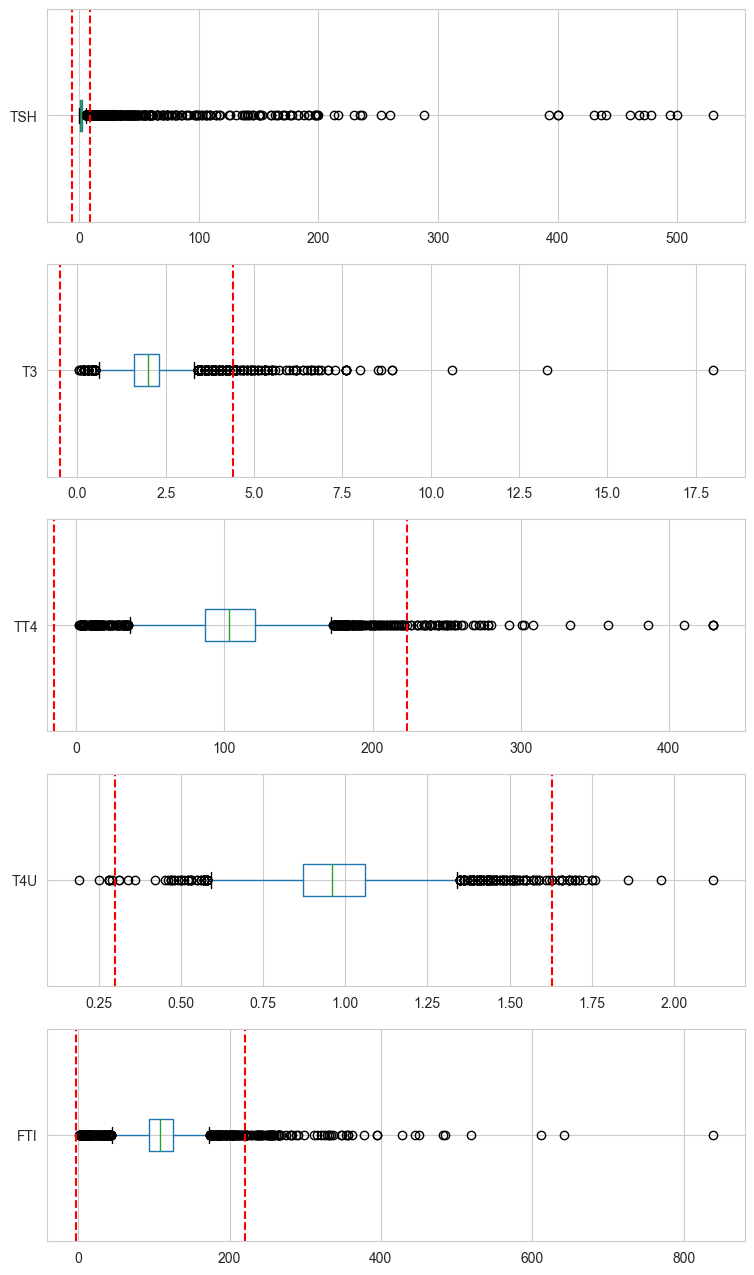

In [24]:
# preparing boxplots
fig, axs= plt.subplots(nrows = 5, figsize=(9,16))

# TSH
data.boxplot(column='TSH', ax=axs[0], vert = False)
axs[0].axvline(x=(Q1_TSH - 3*IQR_TSH), color='r', linestyle='--')
axs[0].axvline(x=(Q3_TSH + 3*IQR_TSH), color='r', linestyle='--')
# T3
data.boxplot(column='T3', ax=axs[1], vert = False)
axs[1].axvline(x=(Q1_T3 - 3*IQR_T3), color='r', linestyle='--')
axs[1].axvline(x=(Q3_T3 + 3*IQR_T3), color='r', linestyle='--')
# TT4
data.boxplot(column='TT4', ax=axs[2], vert = False)
axs[2].axvline(x=(Q1_TT4 - 3*IQR_TT4), color='r', linestyle='--')
axs[2].axvline(x=(Q3_TT4 + 3*IQR_TT4), color='r', linestyle='--')
# T4U
data.boxplot(column='T4U', ax=axs[3], vert = False)
axs[3].axvline(x=(Q1_T4U - 3*IQR_T4U), color='r', linestyle='--')
axs[3].axvline(x=(Q3_T4U + 3*IQR_T4U), color='r', linestyle='--')
# FTI
data.boxplot(column='FTI', ax=axs[4], vert = False)
axs[4].axvline(x=(Q1_FTI - 3*IQR_FTI), color='r', linestyle='--')
axs[4].axvline(x=(Q3_FTI + 3*IQR_FTI), color='r', linestyle='--')

It seems that we have many severe outliers present. However, given our research about these values, this type of variance is normal within this context and is to be expected, especially when dealing with persons who will have alterations in these values given their medical conditions.

Investigating Missing Values

First we will do some calculations to determine the severity of our missing value problem. The custom function below takes a dataframe as input and keeps a tally of missing values per column, then calculates the percentage of missing values in that column and summarizes the information in an output dataframe that is easy for us to viasualize.

The overall missingess of our dataset is 7.54%
This seems worrying at first but most of that bulk is because of the TBG column which is almost entirely empty. We knew we were dropping this from the start of the analysis but have kept it for exploration purposes. Now it is time to go for it.
T3 is second most missing column at 29.3%
This is a lot of missing data and it might be adviseable to remove but the column is too important for our analysis (we have also done separate research that has reiterated that T3 is a very important predictor for thyroid disease). We will try to impute this information moving forward.
TSH is third most missing column at 9.56%
This is a good candidate for imputation moving forward
FTI is our fourth most missing column at 8.86%
This is also a good candidate for imputation
TT4 is our fifth most missing column at 4.69%
Once again a good candidate for imputation
sex is our sixth most missing column at 3.31%
We will determine what to do with sex later on
depending on how important it is to keep in our dataset for modeling purposes we will attempt to impute
age has 4 missing values
we created these values by removing the inconsistent (very large) age for these observation
we determined we can go ahead and drop these observations without impacting our analysis


Observations:

It doesnt seem lke a coincidence that most missing values present are from blood tests
We need to investigate this further in order to decide the best approach to handling them
Are they not there because they weren't properly recorded or because they were never ordered to be taken (deemed not necessary by doctors)?
We will determine what to do with sex later on
depending on how important it is to keep in our dataset for modeling purposes we will attempt to impute
age has 4 missing values
we created these values by removing the inconsistent (very large) age for these observation
we determined we can go ahead and drop these observations without impacting our analysis

In [25]:
# calculating missingess of entire DF
missingness = data.isnull().sum().sum() / data.count().sum()
print('Overall Missingness of data is: {:.2f}%'.format(missingness * 100))

Overall Missingness of data is: 7.54%


In [26]:
# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [27]:
# Analyze missing data
missing_table(data).head(10)

,Total,Percent
TBG,7287,0.965677
T3,2209,0.292738
TSH,722,0.095680
T4U,676,0.089584
FTI,669,0.088656
TT4,354,0.046912
sex,250,0.033130
age,4,0.000530
goitre,0,0.000000
psych,0,0.000000


Missing Table Summary
data['TBG'] – 96.56% missing

The 'TBG' attribute is almost entirely missing from the dataset. This column will be removed at once!
data['age'] – 0.045% missing

We will also go ahead and drop these 4 observations from the dataset. All 4 of these observations belong to observations with 'target' == 'negative'
data['Sex'] – 3.37% missing

There are a total of 300 observations where 'sex' is null. In an attempt to preserve some of these values, we check how many of these observations also have 'pregnant' == True. There are 3 such observations. Assuming the 'pregnancy' attribute is correct for these observations, we can confidently say these 3 observations belong to women and can change their respective values.

In [28]:
# dropping 'TBG' attribute from dataset
data.drop(['TBG'], axis=1, inplace=True)

# dropping 4 observations with abnormal 'age' from dataset
data.dropna(subset=['age'], inplace=True)

In [29]:
# changing sex of observations with ('pregnant' == True) & ('sex' == null) to Female
data['sex'] = np.where((data.sex.isnull()) & (data.pregnant == 't'), 'F', data.sex)

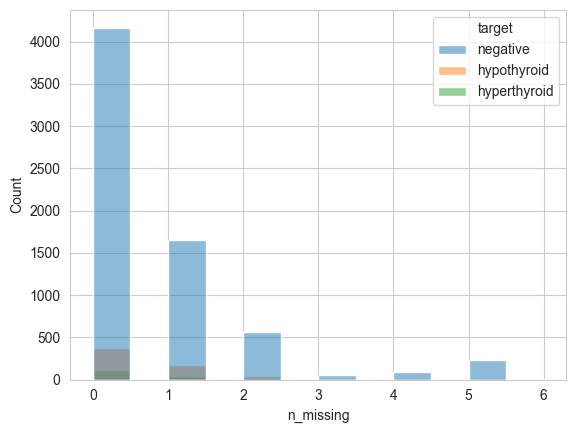

In [30]:
# count missing values per row
data['n_missing'] = data.isnull().sum(axis=1)
sns.histplot(data, x='n_missing', binwidth=0.5, hue='target');

It looks like after removing TBG from the dataset, most of the observations in our dataset have zero missing values. A lot have one missing value and some have two. a minority have 3 or more. Before we do any imputation we will remove the observations that are missing data for more than 2 columns. This is because we dont want to make up observations alltogether. We do this removal in the code below, as well as generate a final table for missing values after we handled most of them.

We are now at only 2.89% missing data throughout the dataset overall!

In [31]:
# calculating missingess of entire DF
missingness = data.isnull().sum().sum() / data.count().sum()
print('Overall Missingness of data is: {:.2f}%'.format(missingness * 100))

Overall Missingness of data is: 2.89%


In [32]:
# remove rows with 3 or more missing values
data.drop(data.index[data['n_missing'] > 2], inplace=True)
print
missing_table(data).head(10)

,Total,Percent
T3,1910,0.267432
TSH,406,0.056847
T4U,290,0.040605
FTI,283,0.039625
sex,208,0.029123
TT4,6,0.000840
age,0,0.000000
goitre,0,0.000000
target,0,0.000000
psych,0,0.000000


Preprocessing for XGBoost

In [33]:
# replacing boolean strings with binary 0 and 1
data.replace('f', 0, inplace=True)
data.replace('t', 1, inplace=True)

# replacing sex with binary 0 and 1
data.replace('M', 0, inplace=True) # male mapped to 0
data.replace('F', 1, inplace=True) # female mapped to 1

xgbDF = data.replace(np.nan, 0)

# re-mapping target vaues to diagnostic groups
# *** I get different final results by ordering these classes differently ***
diagnoses = {'negative': 0,
             'hypothyroid': 1, 
             'hyperthyroid': 2}

xgbDF['target'] = xgbDF['target'].map(diagnoses) # re-mapping

# train and test split --> stratified
X = xgbDF.drop('target', axis=1).copy()
y = xgbDF['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, stratify=y)

XGBoost model v1

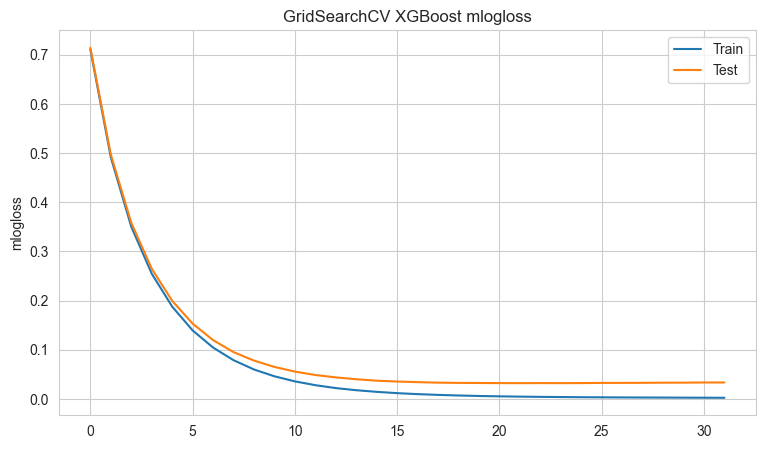

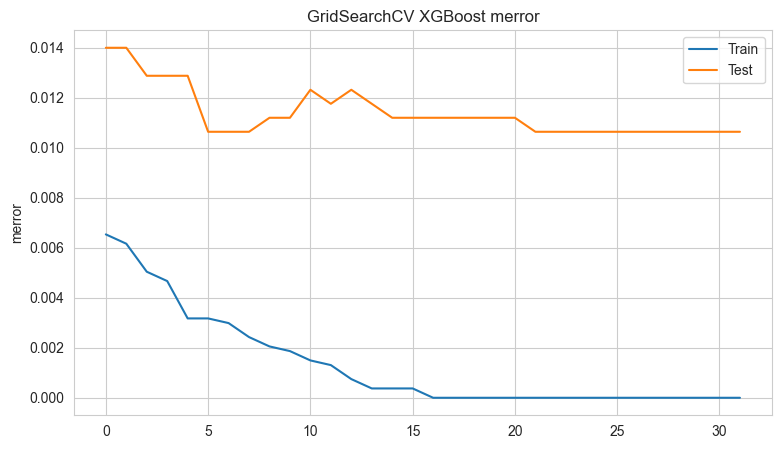


------------------ Confusion Matrix -----------------

[[1584    2   11]
 [   0  145    0]
 [   6    0   38]]

-------------------- Key Metrics --------------------

Accuracy: 0.99
Balanced Accuracy: 0.95

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.92
Macro Recall: 0.95
Macro F1-score: 0.93

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1597
           1       0.99      1.00      0.99       145
           2       0.78      0.86      0.82        44

    accuracy                           0.99      1786
   macro avg       0.92      0.95      0.93      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [34]:
## ---------- XGBoost model v1 ----------
## base run of model with default hyperparameters

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

XGBoost model v2

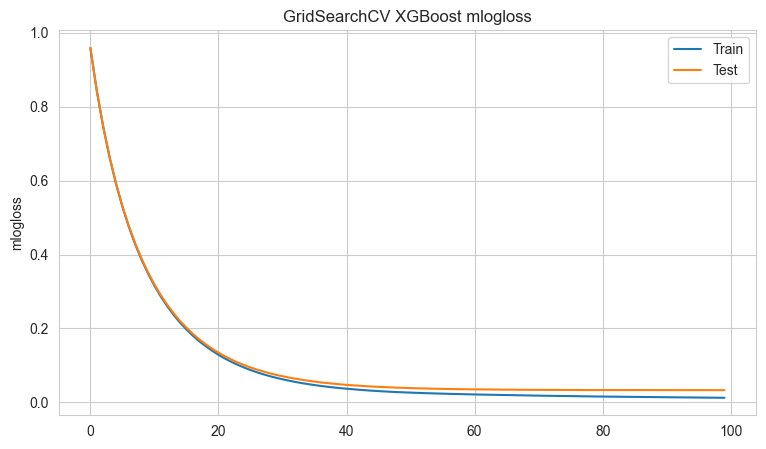

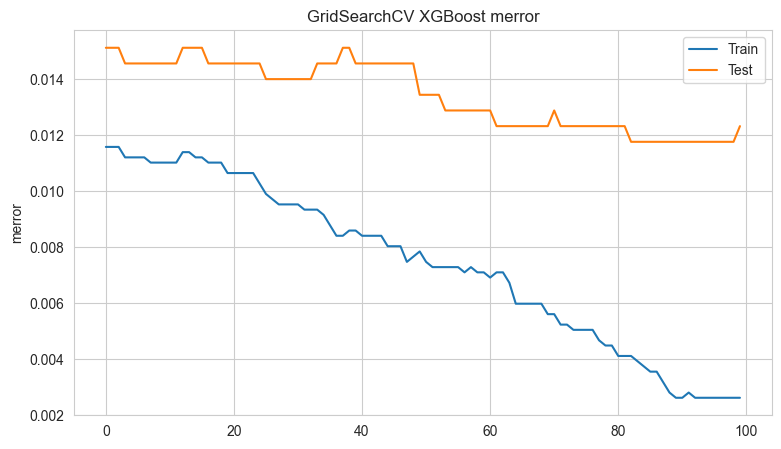


------------------ Confusion Matrix -----------------

[[1582    3   12]
 [   0  145    0]
 [   7    0   37]]

Accuracy: 0.99
Balanced Accuracy: 0.94

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.91
Macro Recall: 0.94
Macro F1-score: 0.93

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1597
           1       0.98      1.00      0.99       145
           2       0.76      0.84      0.80        44

    accuracy                           0.99      1786
   macro avg       0.91      0.94      0.93      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [35]:
## ---------- XGBoost model v2 ----------
## second run of model with "optimized" hyperparameters 

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=1, # default L2 value
                            subsample=1, # default subsample value
                            colsample_bytree=1, # default colsample_bytree value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            #sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

XGBoost Model v3

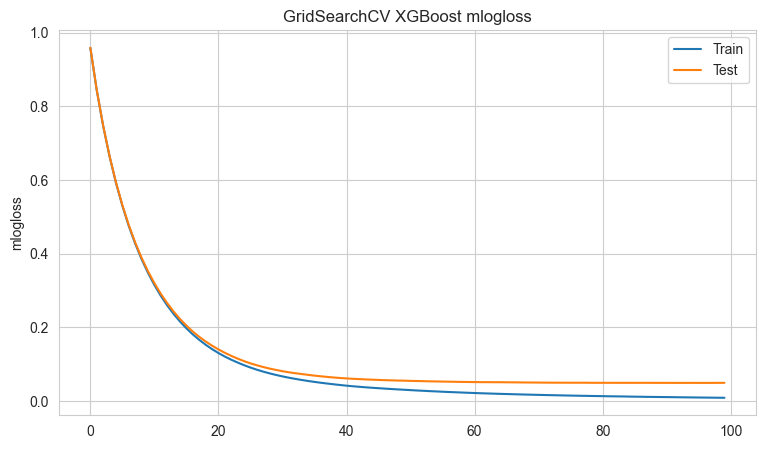

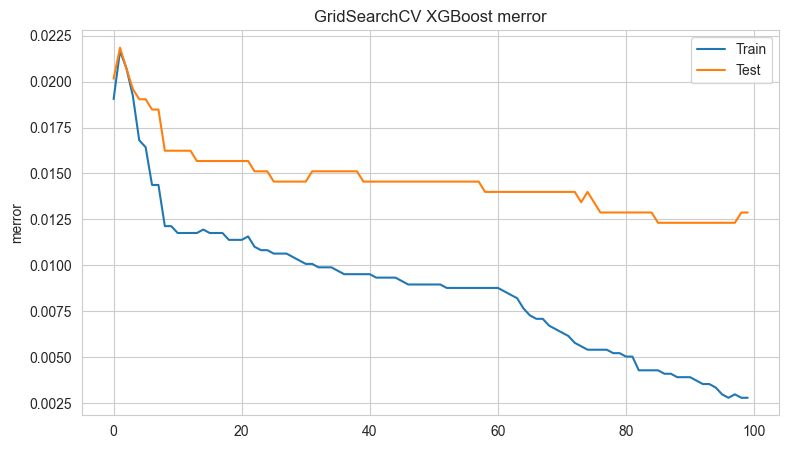


------------------ Confusion Matrix -----------------

[[1578    5   14]
 [   0  145    0]
 [   3    0   41]]

Accuracy: 0.99
Balanced Accuracy: 0.97

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.90
Macro Recall: 0.97
Macro F1-score: 0.93

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1597
           1       0.97      1.00      0.98       145
           2       0.75      0.93      0.83        44

    accuracy                           0.99      1786
   macro avg       0.90      0.97      0.93      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [36]:
## ---------- XGBoost model v3 ----------
## third run of model with "optimized" hyperparameters and
## attempting to treat unbalanced target classes

# balancing 'target' class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=5, # re-optimized from v2
                            reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling


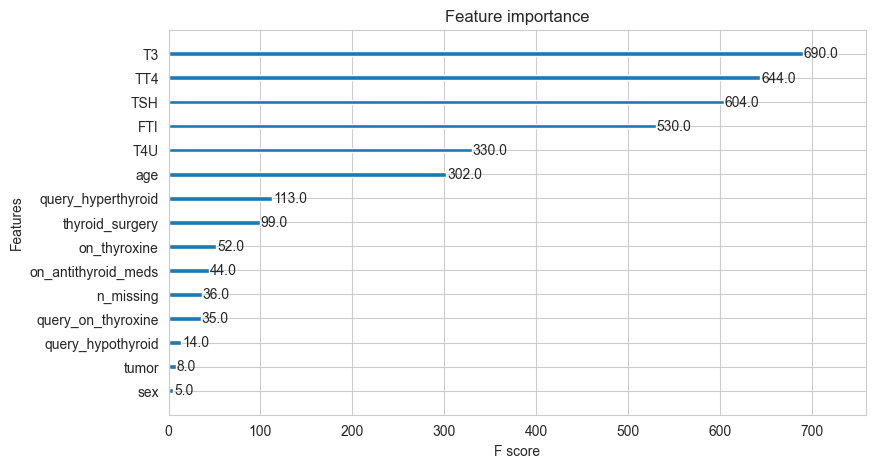

In [37]:
## ---------- Plot Feature Importance ----------
## plotting feature importance of best xgboost model (v3)

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1597
           1       0.97      1.00      0.98       145
           2       0.75      0.93      0.83        44

    accuracy                           0.99      1786
   macro avg       0.90      0.97      0.93      1786
weighted avg       0.99      0.99      0.99      1786



In [39]:
accuracy_score(y_test, y_pred)*100

98.76819708846585

In [40]:
#Number of trees in the random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features =  ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth =  [2,41]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [41]:
# create the param_grid
param_grid = {'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_leaf' : min_samples_leaf,
    'min_samples_split' : min_samples_split,
    'bootstrap' : bootstrap}
print(param_grid)


{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 41], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'bootstrap': [True, False]}


In [42]:
rf = RandomForestClassifier()

In [43]:
rf_Grid = GridSearchCV(estimator= rf, param_grid = param_grid, cv = 3, verbose = 2, n_jobs= 4 )

In [44]:
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 41],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [45]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 41,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 80}

In [46]:
y_pred1 = rf_Grid.predict(X_test)

print(y_pred1)

[2 0 0 ... 0 0 0]


In [47]:
accuracy_score(y_test, y_pred1)*100

99.10414333706606